$$
\frac{dx}{dt}=-x+R(\psi)\cos\psi-\alpha y(t)\omega(t)+\beta\cos(\psi_{0}(t)-\theta_{0})\\
\frac{dy}{dt}=-y+R(\psi)\sin\psi+\alpha x(t)\omega(t)+\beta\sin(\psi_{0}(t)-\theta_{0})
$$
$$
\frac{dr}{dt}=-r+R(\psi)+\beta\cos(\psi_{0}(t)-\theta_{0}-\psi(t))\\
\frac{d\psi}{dt}=\alpha\omega(t)+\frac{\beta}{r}\sin(\psi_{0}(t)-\theta_{0}-\psi(t))
$$
$$
R(r,\psi)=R_{0}+r\varepsilon\cos(\psi-\phi_{0})\\
\alpha=\frac{1}{1+\sigma_{v}^{2}},\,\,\beta=\frac{h}{\sigma_{h}^{2}(\sigma_{v}^{-2}+1)}
$$

In [47]:
import numpy as np
from scipy.integrate import solve_ivp
import seaborn as sns
import matplotlib.pyplot as plt


## Star ODE without function approximation

In [198]:

# Define the function for the system of ODEs
def eps_star_euclid_odes(t, state, R0, phi0, eps, sigma_v, sigma_h, h, psi0_f, theta0, omega_f):
    """_summary_

    Args:
        t (_type_): time
        state (_type_): state vector, [x, y]
        R0 (_type_): Base radius of ring manifold
        phi0 (_type_): Phase of the bulge on purturbed ring manifold
        eps (_type_): Amplitude of the perturbation
        sigma_v (_type_): noise scale in velocity
        sigma_h (_type_): noise scale in head direction signal
        h (_type_): amplitude of head direction signal, scalar or function
        psi0_f (_type_): time-varying head direction signal
        theta0 (_type_): phase of the head direction signal (relative to some landmark)
        omega_f (_type_): time-varying angular velocity

    Returns:
        _type_: _description_
    """
    # Unpack variables
    x, y, = state
    r = np.sqrt(x**2 + y**2)
    psi = np.arctan2(y, x)
    # Compute parameters
    alpha = 1 / (1 + sigma_v**2)
    beta = 1 / (sigma_h**2 * (sigma_v**(-2) + 1))
    # R function
    R_psi = R0 + r * eps * np.cos(psi - phi0)
    # Define the ODEs
    if callable(h):
        h = h(t)
    dx_dt = -x + R_psi * np.cos(psi) - alpha * y * omega_f(t) + beta * h * np.cos(psi0_f(t) - theta0)
    dy_dt = -y + R_psi * np.sin(psi) + alpha * x * omega_f(t) + beta * h * np.sin(psi0_f(t) - theta0)    
    return [dx_dt, dy_dt]


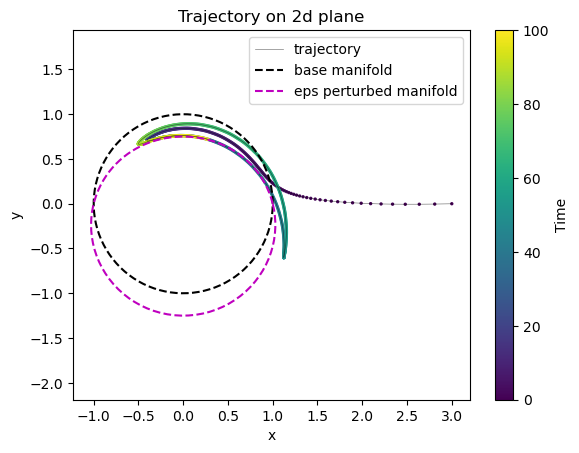

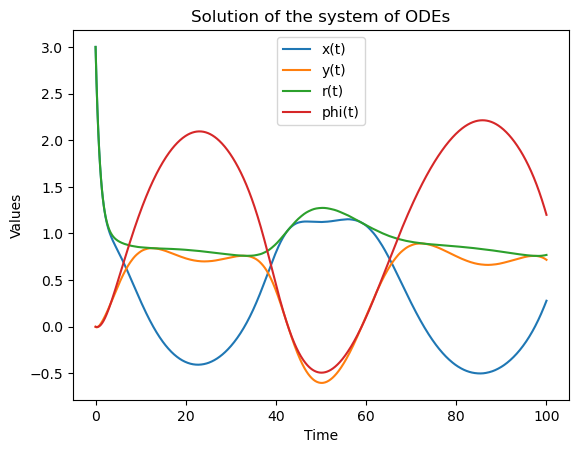

In [199]:
# Time span
t_span = (0, 100)  # From t=0 to t=10
t_eval = np.linspace(0, 100, 1000)  # Points at which to store the solution

# Speed, angular velocity, and head direction input signals
omega_fun = lambda t: -0.1
h_fun = lambda t: max(0, 0.1 * (1.5 + np.cos(0.1 * t)))
psi0_fun = lambda t: np.pi/2 + 0.1 * t #-0.2* t  # Example function for psi0
# Manifold Parameters
R0 = 1.0
eps = 0.25
phi0 = - np.pi/2
# Relative confidance in velocity and head direction signal, gating term of input. 
sigma_v = 0.1
sigma_h = 0.1
# h = 0.5
theta0 = 0.0 # this one is useless, can be combined into psi0
# Initial conditions
y0 = [3.0, 0.0,]  # Initial values for x, x_dot, r, psi
# Solve the system of ODEs
sol = solve_ivp(eps_star_euclid_odes, t_span, y0, t_eval=t_eval, 
                args=(R0, phi0, eps, sigma_v, sigma_h, h_fun, psi0_fun, theta0, omega_fun))

plt.figure()
# plot x, y on the 2d plane, colored by sol.t, add line connecting the points
plt.scatter(sol.y[0], sol.y[1], c=sol.t, lw=1, cmap='viridis', s=2, )
plt.plot(sol.y[0], sol.y[1], lw=0.5, c='k', alpha=0.5, label='trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar(label='Time')
# plot the unit circle
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(R0 *np.cos(theta), R0 *np.sin(theta), 'k--', label="base manifold")
plt.plot(R0 * (1 + eps * np.cos(theta - phi0)) * np.cos(theta),
         R0 * (1 + eps * np.cos(theta - phi0)) * np.sin(theta), 
        'm--', label="eps perturbed manifold")
plt.axis('equal')
plt.title('Trajectory on 2d plane')
plt.legend()
plt.show()

plt.figure()
plt.plot(sol.t, sol.y[0], label='x(t)')
plt.plot(sol.t, sol.y[1], label='y(t)')
# compute r, phi
r = np.sqrt(sol.y[0]**2 + sol.y[1]**2)
phi = np.arctan2(sol.y[1], sol.y[0])
plt.plot(sol.t, r, label='r(t)')
plt.plot(sol.t, phi, label='phi(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Solution of the system of ODEs')
plt.show()

In [200]:
import numpy as np
from scipy.integrate import solve_ivp
import math
import matplotlib.pyplot as plt

def normalize_angle(angle):
    # Use modulo operation to normalize the angle within -pi to pi range directly
    return (angle + math.pi) % (2 * math.pi) - math.pi


def plot_trajectory_on_2d_plane(omega_fun, h_fun, psi0_fun, theta0=0.0, 
                                R0=1.0, eps=0.0, phi0=np.pi / 2, 
                                sigma_v=0.1, sigma_h=0.1, 
                                y0=np.array([2.0, 0.0]),
                                t_span=[0, 100], 
                                t_eval=np.linspace(0, 100, 1000)):
    def eps_star_euclid_odes(t, state, R0, phi0, eps, sigma_v, sigma_h, h_fun, psi0_fun, theta0, omega_fun):
        x, y = state
        r = np.sqrt(x**2 + y**2)
        psi = np.arctan2(y, x)
        alpha = 1 / (1 + sigma_v**2)
        beta = 1 / (sigma_h**2 * (sigma_v**(-2) + 1))
        R_psi = R0 + r * eps * np.cos(psi - phi0)
        if callable(h_fun):
            h = h_fun(t)
        dx_dt = -x + R_psi * np.cos(psi) - alpha * y * omega_fun(t) + beta * h * np.cos(psi0_fun(t) - theta0)
        dy_dt = -y + R_psi * np.sin(psi) + alpha * x * omega_fun(t) + beta * h * np.sin(psi0_fun(t) - theta0)    
        return [dx_dt, dy_dt]

    sol = solve_ivp(eps_star_euclid_odes, t_span, y0, t_eval=t_eval, 
                    args=(R0, phi0, eps, sigma_v, sigma_h, h_fun, psi0_fun, theta0, omega_fun))

    r = np.sqrt(sol.y[0]**2 + sol.y[1]**2)
    phi = np.arctan2(sol.y[1], sol.y[0])
    # plot the trajectory on 2d plane
    plt.figure()
    plt.scatter(sol.y[0], sol.y[1], c=sol.t, lw=1, cmap='viridis', s=2)
    plt.plot(sol.y[0], sol.y[1], lw=0.5, c='k', alpha=0.5, label='trajectory')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar(label='Time')
    theta = np.linspace(0, 2*np.pi, 100)
    plt.plot(R0 *np.cos(theta), R0 *np.sin(theta), 'k--', label="base manifold")
    plt.plot(R0 * (1 + eps * np.cos(theta - phi0)) * np.cos(theta),
             R0 * (1 + eps * np.cos(theta - phi0)) * np.sin(theta), 
            'm--', label="eps perturbed manifold")
    plt.axis('equal')
    plt.title('Trajectory on 2d plane')
    plt.legend()
    plt.show()
    # plot the 2d head direction signal and angular velocity
    h_vec = np.array([h_fun(t) for t in sol.t])
    psi0_vec = np.array([psi0_fun(t) for t in sol.t])
    omega_vec = np.array([omega_fun(t) for t in sol.t])
    omege_cumsum = np.cumsum(omega_vec) * (sol.t[1] - sol.t[0]) + phi[0]
    plt.figure()
    plt.scatter(h_vec * np.cos(psi0_vec), h_vec * np.sin(psi0_vec), c=sol.t, lw=1, cmap='viridis', s=2, 
                label='2d head direction signal')
    plt.plot(h_vec * np.cos(psi0_vec), h_vec * np.sin(psi0_vec), lw=0.5, c='k', alpha=0.5)
    plt.scatter(np.cos(omege_cumsum), np.sin(omege_cumsum), c=sol.t, lw=1, cmap='viridis', s=2, 
                label='angular velocity integration')
    plt.plot(np.cos(omege_cumsum), np.sin(omege_cumsum), lw=0.5, c='k', alpha=0.5)
    plt.legend()
    plt.axis('equal')
    plt.title('2d head direction signal and angular velocity integration')
    plt.show()
    # plot input signals as time sequence
    plt.figure(figsize=(8, 4.5))
    plt.plot(sol.t, h_vec, label='h(t)')
    plt.plot(sol.t, normalize_angle(psi0_vec), label='psi0(t)')
    plt.plot(sol.t, omega_vec, label='omega(t)')
    plt.plot(sol.t, normalize_angle(omege_cumsum), label='\Int omega(t)')
    plt.xlabel('Time')
    plt.ylabel('Input signals')
    plt.legend() 
    plt.title('Input signals')
    plt.show()
    # plot the solution as time sequence
    plt.figure(figsize=(8, 4.5))
    plt.plot(sol.t, sol.y[0], label='x(t)')
    plt.plot(sol.t, sol.y[1], label='y(t)')
    plt.plot(sol.t, r, label='r(t)')
    plt.plot(sol.t, phi, label='phi(t)')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.title('Solution of the system of ODEs')
    plt.show()
    

Tracking head direction signal with varying confidence level

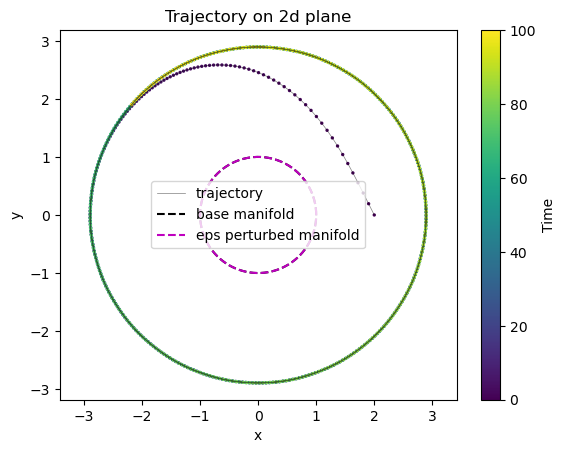

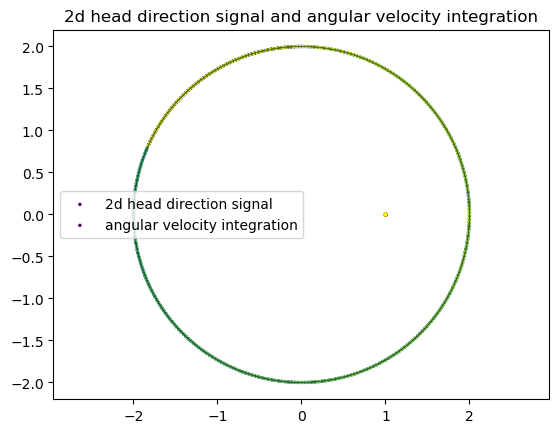

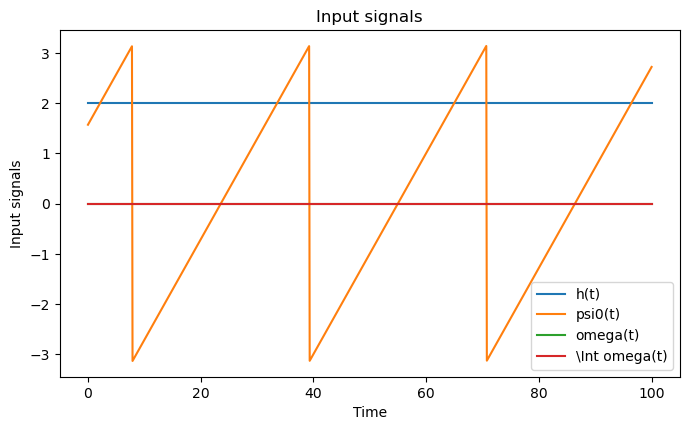

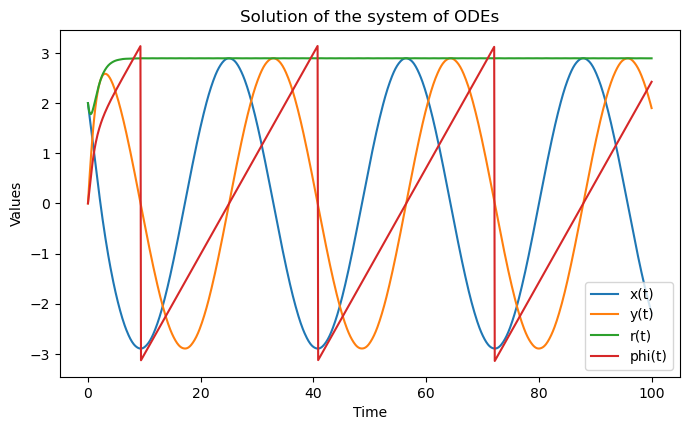

In [201]:
omega_fun = lambda t: 0.0
h_fun = lambda t: 2#np.clip(1 * (1.1 + np.cos(0.1 * t)), 0.0, None)
psi0_fun = lambda t: np.pi/2 + 0.2 * t #-0.2* t  # Example function for psi0
plot_trajectory_on_2d_plane(omega_fun, h_fun, psi0_fun, eps=0.0)

### Conflicting cue experiments

When velocity and head direction cue have conflicting speed 

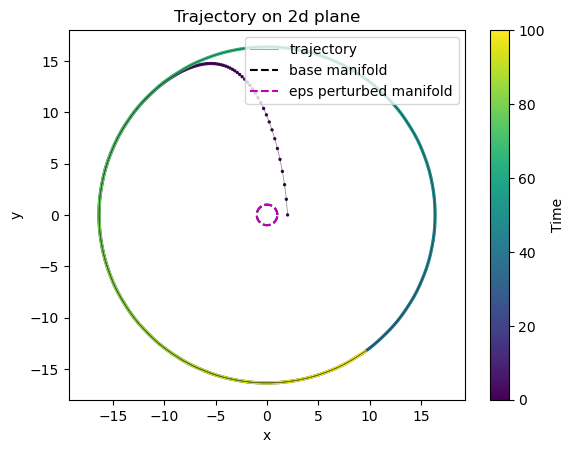

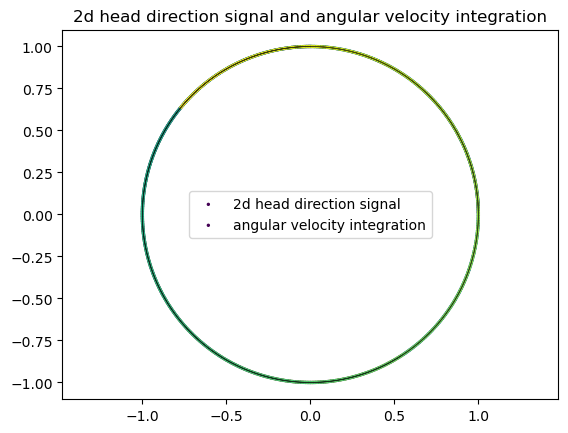

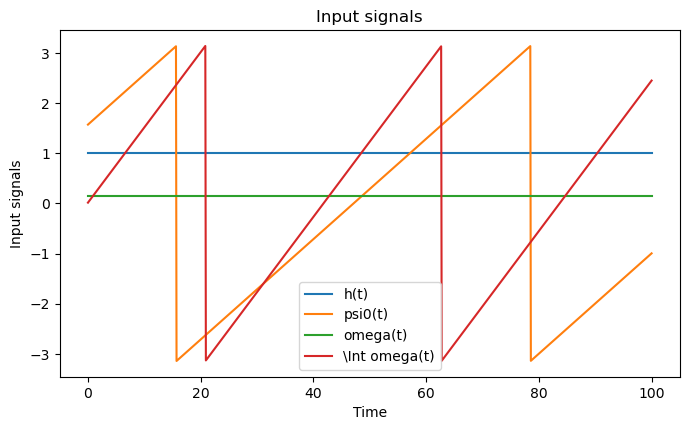

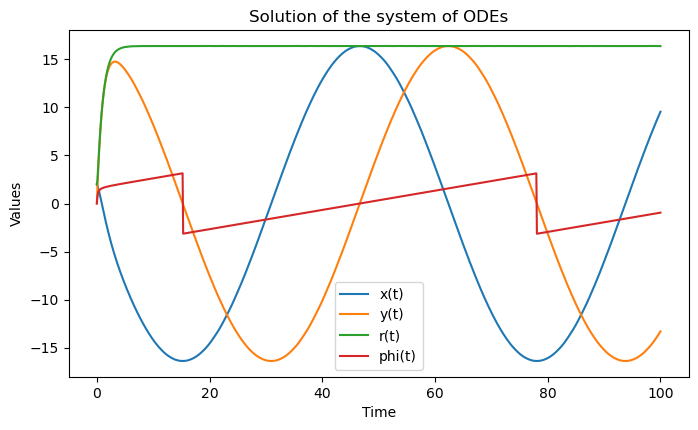

In [202]:
omega_fun = lambda t: 0.15
h_fun = lambda t: 1 #np.clip(1 * (1.1 + np.cos(0.1 * t)), 0.0, None)
psi0_fun = lambda t: np.pi/2 + 0.1 * t #-0.2* t  # Example function for psi0
plot_trajectory_on_2d_plane(omega_fun, h_fun, psi0_fun, eps=0.0, sigma_v=0.2, sigma_h=0.05)

## Star ODE with Function approximation system

### Utils for plotting

In [33]:
import math
def normalize_angle(angle):
    # Use modulo operation to normalize the angle within -pi to pi range directly
    return (angle + math.pi) % (2 * math.pi) - math.pi

### Learning

In [8]:
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm, trange
import numpy as np


In [9]:
def target_function(x, y, omega, x0, y0, Hx, Hy, 
                    sigma_v=1.0, sigma_h=1.0, R0=1.0, ):
    """ Target function for the ODE system 
    Input
      x, y
      omega
      x0, y0
      Hx, Hy 
    Output
      dx, dy
    """
    alpha = 1 / (1 + sigma_v**2)
    beta  = 1 / (sigma_h**2 * (sigma_v**(-2) + 1))
    R_f = R0 + x0 * x + y0 * y
    r = np.sqrt(x**2 + y**2)
    dx = -x + R_f * x / r - alpha * y * omega + Hx
    dy = -y + R_f * y / r + alpha * x * omega + Hy
    return dx, dy

In [ ]:
# sample dataset 
np.random.seed(0)
n_samples = 10000

x = np.random.randn(n_samples)
y = np.random.randn(n_samples)
omega_lim = [-0.2,0.2]
omega = np.random.uniform(omega_lim[0], omega_lim[1], n_samples)
x0norm = 0.1
x0 = np.random.randn(n_samples) * x0norm
y0 = np.random.randn(n_samples) * x0norm
Hx = np.random.randn(n_samples) * 0.1
Hy = np.random.randn(n_samples) * 0.1
target_dx, target_dy = target_function(x, y, omega, x0, y0, Hx, Hy)
# train a multi layer perceptron to predict dx, dy
assert target_dx.shape == target_dy.shape

In [5]:
def construct_dataset(n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1, **kwargs):
    np.random.seed(0)
    
    x = np.random.randn(n_samples)
    y = np.random.randn(n_samples)
    omega = np.random.uniform(omega_lim[0], omega_lim[1], n_samples)
    x0 = np.random.randn(n_samples) * x0norm
    y0 = np.random.randn(n_samples) * x0norm
    Hx = np.random.randn(n_samples) * 0.1
    Hy = np.random.randn(n_samples) * 0.1
    
    target_dx, target_dy = target_function(x, y, omega, x0, y0, Hx, Hy, **kwargs)
    
    assert target_dx.shape == target_dy.shape == x.shape == y.shape == omega.shape == x0.shape == y0.shape == Hx.shape == Hy.shape
    
    return x, y, omega, x0, y0, Hx, Hy, target_dx, target_dy



In [6]:
def build_MLP(n_width, n_depth, activation=nn.ReLU,
              input_dim=7, output_dim=2):
    layers = []
    layers.append(nn.Linear(input_dim, n_width))
    layers.append(nn.ReLU())
    for i in range(n_depth-1):
        layers.append(nn.Linear(n_width, n_width))
        layers.append(activation())
    layers.append(nn.Linear(n_width, output_dim))
    model = nn.Sequential(*layers)
    return model


def construct_torch_dataset(n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1, **kwargs):
    x, y, omega, x0, y0, Hx, Hy, target_dx, target_dy = construct_dataset(n_samples, omega_lim, x0norm, **kwargs)
    dataset = TensorDataset(torch.tensor(np.stack([x, y, omega, x0, y0, Hx, Hy], axis=1), dtype=torch.float32),
                        torch.tensor(np.stack([target_dx, target_dy], axis=1), dtype=torch.float32))
    return dataset

dataset = construct_torch_dataset(n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1, R0=1.0, sigma_v=0.1, sigma_h=0.1)
# make a torch dataset of these, and train a MLP to predict dx, dy
model = build_MLP(64, 1)

In [ ]:
# optimize model
dataset = construct_torch_dataset(n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1,
                                  R0=1.0, sigma_v=0.1, sigma_h=0.1)
# make a torch dataset of these, and train a MLP to predict dx, dy
n_depth, n_width = 1, 128
model = build_MLP(n_width, n_depth)
optimizer = Adam(model.parameters(), lr=1e-3)
loss_fn = F.mse_loss
n_epochs = 10000
# use full batch update 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x_batch, y_batch = dataset.tensors
x_batch = x_batch.to(device)
y_batch = y_batch.to(device)
model.to(device)
model.train()
pbar = tqdm(range(n_epochs))
for epoch in pbar:    
    optimizer.zero_grad()
    y_pred = model(x_batch)
    loss = loss_fn(y_pred, y_batch)
    loss.backward()
    optimizer.step()
    pbar.set_postfix({'loss': loss.item()})
    if epoch % 500 == 0 or (epoch == 0):
        print(f'epoch {epoch}, loss: {loss.item()}')

In [12]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from tqdm.auto import tqdm

def train_MLP(dataset, model=None, n_depth=1, n_width=128, 
              lr=1e-3, n_epochs=10000, print_every=500):
    # n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1, R0=1.0, sigma_v=0.1, sigma_h=0.1
    # Construct dataset
    if dataset is None:
        n_samples = 10000
        omega_lim = (-0.2, 0.2)
        x0norm = 0.1
        R0 = 1.0
        sigma_v = 0.1
        sigma_h = 0.1
        dataset = construct_torch_dataset(n_samples=n_samples, omega_lim=omega_lim, x0norm=x0norm,
                                      R0=R0, sigma_v=sigma_v, sigma_h=sigma_h)
    
    # Build model
    if model is None:
        model = build_MLP(n_width, n_depth)
    optimizer = Adam(model.parameters(), lr=lr)
    loss_fn = F.mse_loss
    
    # Prepare for training
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    x_batch, y_batch = dataset.tensors
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    model.to(device)
    model.train()
    
    # Training loop
    pbar = tqdm(range(n_epochs))
    for epoch in pbar:    
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        pbar.set_postfix({'loss': loss.item()})
        if epoch % print_every == 0 or (epoch == 0) or (epoch == n_epochs-1):
            print(f'epoch {epoch}, loss: {loss.item()}')
    
    return model

In [44]:
# optimize model
dataset = construct_torch_dataset(n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1,
                                  R0=1.0, sigma_v=0.1, sigma_h=0.1)
# make a torch dataset of these, and train a MLP to predict dx, dy
n_depth, n_width = 1, 128
model = build_MLP(n_width, n_depth)
optimizer = Adam(model.parameters(), lr=1e-3)
loss_fn = F.mse_loss
n_epochs = 10000
# use full batch update 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x_batch, y_batch = dataset.tensors
x_batch = x_batch.to(device)
y_batch = y_batch.to(device)
model.to(device)
model.train()
pbar = tqdm(range(n_epochs))
for epoch in pbar:    
    optimizer.zero_grad()
    y_pred = model(x_batch)
    loss = loss_fn(y_pred, y_batch)
    loss.backward()
    optimizer.step()
    pbar.set_postfix({'loss': loss.item()})
    if epoch % 500 == 0 or (epoch == 0):
        print(f'epoch {epoch}, loss: {loss.item()}')

  0%|          | 0/10000 [00:00<?, ?it/s]

epoch 0, loss: 0.30651557445526123
epoch 500, loss: 0.014743396081030369
epoch 1000, loss: 0.008406534790992737
epoch 1500, loss: 0.005289338529109955
epoch 2000, loss: 0.003122317837551236
epoch 2500, loss: 0.0021198010072112083
epoch 3000, loss: 0.0016969096614047885
epoch 3500, loss: 0.0014606248587369919
epoch 4000, loss: 0.0013027603272348642
epoch 4500, loss: 0.0011887840228155255
epoch 5000, loss: 0.0011005940614268184
epoch 5500, loss: 0.0010335535043850541
epoch 6000, loss: 0.0009702313109301031
epoch 6500, loss: 0.0009314821218140423
epoch 7000, loss: 0.0008776712347753346
epoch 7500, loss: 0.0008455488132312894
epoch 8000, loss: 0.0008145690662786365
epoch 8500, loss: 0.0007953739259392023
epoch 9000, loss: 0.0007750624790787697
epoch 9500, loss: 0.0007688460755161941


In [31]:
dataset = construct_torch_dataset(n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1, 
                                  R0=1.0, sigma_v=0.1, sigma_h=0.1)
n_depth, n_width = 1, 128
model = train_MLP(dataset, model=None, n_depth=n_depth, n_width=n_width, 
          lr=1e-3, n_epochs=10000, print_every=1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

epoch 0, loss: 0.31978482007980347
epoch 1000, loss: 0.008470849134027958
epoch 2000, loss: 0.0030101474840193987
epoch 3000, loss: 0.0016705859452486038
epoch 4000, loss: 0.0013266861205920577
epoch 5000, loss: 0.001134418067522347
epoch 6000, loss: 0.0010277648689225316
epoch 7000, loss: 0.0009209760464727879
epoch 8000, loss: 0.0008449297747574747
epoch 9000, loss: 0.0007872867281548679
epoch 9999, loss: 0.000749825150705874


Desired manifold 
$$
r(\phi)=\frac{R_0}{1-x_0\cos\phi-y_0\sin\phi}
$$

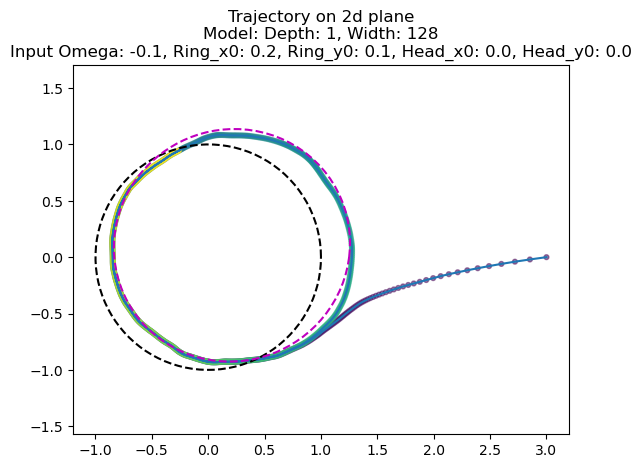

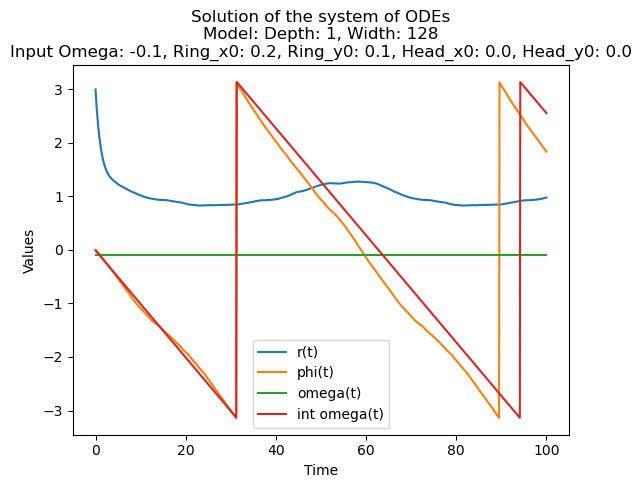

In [46]:
from torchdiffeq import odeint
# build ode function and solve it with torch model
@torch.no_grad()
def ode_function(t, xy, ):
    dx_dy = model(torch.concat([xy, ctrl_inps(t)]))
    return dx_dy

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# solve the ode with torch model
t_span = (0, 100)
t_eval = torch.linspace(*t_span, 1000)
omega0 = -0.1
ring_x0, ring_y0 = 0.2, 0.1
# H_x0, H_y0 = 0.05, 0.05
H_x0, H_y0 = 0.00, 0.00
ctrl_inps = lambda t: torch.tensor([omega0, ring_x0, ring_y0, H_x0, H_y0], dtype=torch.float32, device=device)
y0 = torch.tensor([3.0, 0.0], dtype=torch.float32, device=device)
sol = odeint(ode_function, y0, t_eval, ).cpu()# model, ctrl_inps
expstr = f'Model: Depth: {n_depth}, Width: {n_width}\nInput Omega: {omega0}, Ring_x0: {ring_x0}, Ring_y0: {ring_y0}, Head_x0: {H_x0}, Head_y0: {H_y0}'
R0 = 1
plt.figure()
plt.plot(sol[:, 0], sol[:, 1])
plt.scatter(sol[:, 0], sol[:, 1], c=t_eval, 
            s=12, cmap='viridis', alpha=0.5)
#plot unit circle
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(R0 * np.cos(theta), R0 * np.sin(theta), 'k--')
R_f = R0 / (1 - ring_x0 * np.cos(theta) - ring_y0 * np.sin(theta))
plt.plot(R_f * np.cos(theta), R_f * np.sin(theta), 
        'm--', label="perturbed manifold")
plt.axis('equal')
plt.title(f'Trajectory on 2d plane\n{expstr}')
plt.show()

r = torch.sqrt(sol[:, 0]**2 + sol[:, 1]**2)
phi = torch.atan2(sol[:, 1], sol[:, 0])
omega_t = torch.tensor([ctrl_inps(t)[0] for t in t_eval], dtype=torch.float32)
omega_int = torch.cumsum(omega_t, dim=0) * (t_eval[1] - t_eval[0]) + phi[0]

plt.figure()
plt.plot(t_eval, r, label='r(t)')
plt.plot(t_eval, phi, label='phi(t)')
plt.plot(t_eval, omega_t, label='omega(t)')
plt.plot(t_eval, normalize_angle(omega_int), label='int omega(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title(f'Solution of the system of ODEs\n{expstr}')
plt.show()

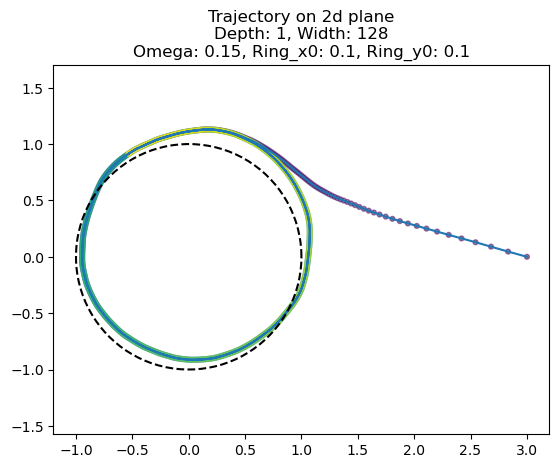

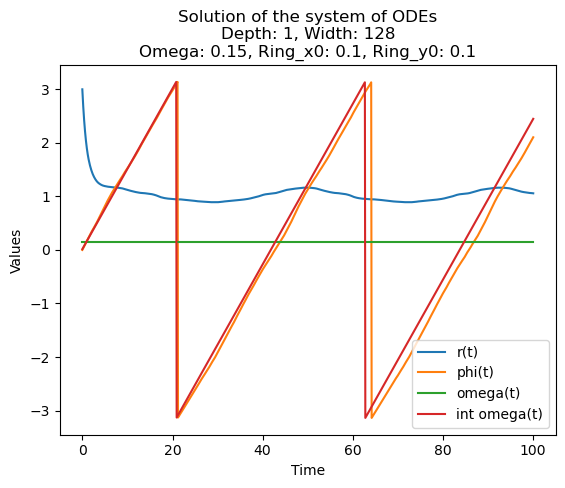

### Look inside the simple MLP model

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
model

Sequential(
  (0): Linear(in_features=7, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=2, bias=True)
)

torch.Size([128, 7]) torch.Size([2, 128])


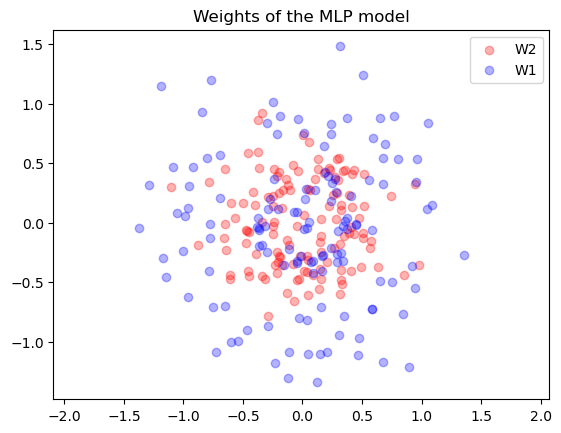

In [22]:
W2 = model[-1].weight.detach().cpu()
W1 = model[0].weight.detach().cpu()
print(W1.shape, W2.shape)
plt.scatter(W2[0, :], W2[1, :], c='r', label='W2',alpha=0.3)
plt.scatter(W1[:, 0], W1[:, 1], c='b', label='W1',alpha=0.3)
plt.legend()
plt.title('Weights of the MLP model')
plt.axis('equal')
plt.show()


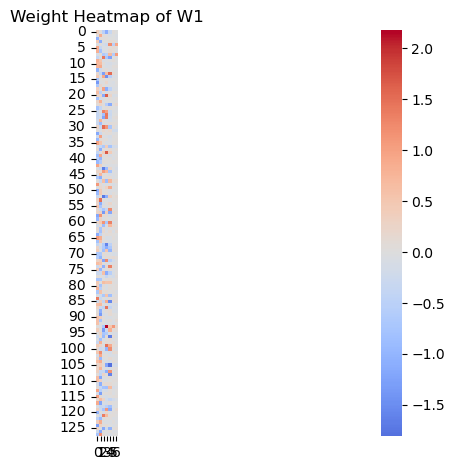

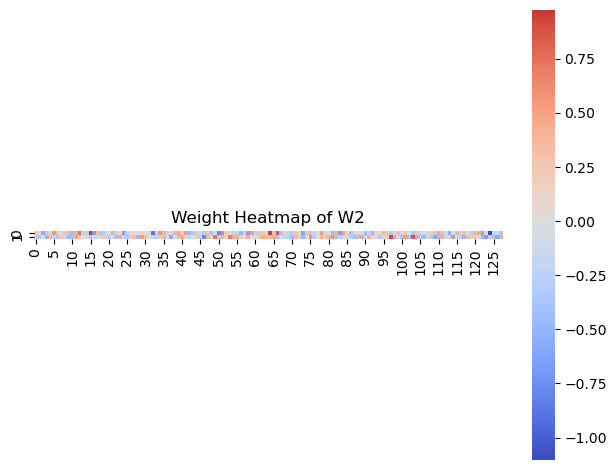

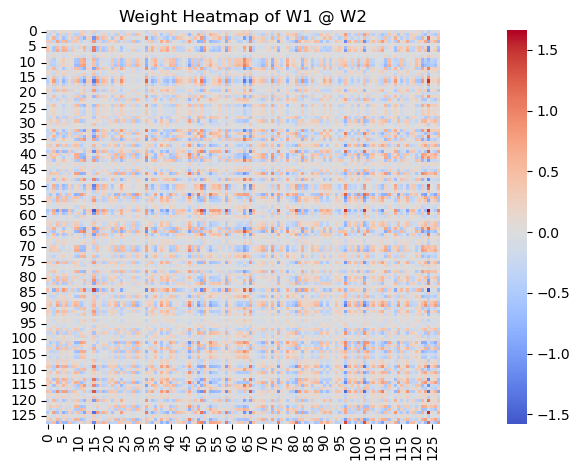

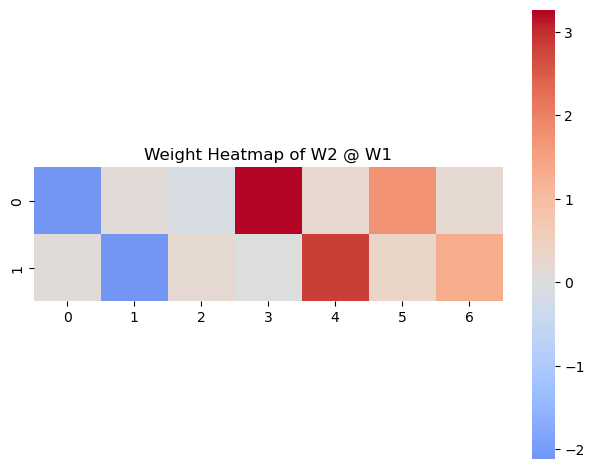

In [27]:
def plot_weight_heatmap(W, title='Weight Heatmap'):
    sns.heatmap(W, cmap='coolwarm', center=0)
    plt.title(title)
    plt.axis('image')
    plt.tight_layout()
    plt.show()
    
plot_weight_heatmap(W1, title='Weight Heatmap of W1')
plot_weight_heatmap(W2, title='Weight Heatmap of W2')
plot_weight_heatmap(W1[:, :2] @ W2, title='Weight Heatmap of W1 @ W2')
plot_weight_heatmap(W2 @ W1, title='Weight Heatmap of W2 @ W1')

### Original scratch space

In [ ]:
x, y, omega, x0, y0, Hx, Hy, target_dx, target_dy = construct_dataset(n_samples=10000, omega_lim=(-0.2, 0.2), x0norm=0.1)

dataset = TensorDataset(torch.tensor(np.stack([x, y, omega, x0, y0, Hx, Hy], axis=1), dtype=torch.float32),
                        torch.tensor(np.stack([target_dx, target_dy], axis=1), dtype=torch.float32))
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
n_width = 128
n_depth = 1
layers = []
layers.append(nn.Linear(7, n_width))
layers.append(nn.ReLU())
for i in range(n_depth-1):
    layers.append(nn.Linear(n_width, n_width))
    layers.append(nn.ReLU())
layers.append(nn.Linear(n_width, 2))
model = nn.Sequential(*layers)

### Full analytical model

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [ ]:

# Define the function for the system of ODEs
def system_euclid_odes(t, state, R0, phi0, sigma_v, sigma_h, h, psi0, theta0, omega, eps):
    # Unpack variables
    x, y, = state
    r = np.sqrt(x**2 + y**2)
    psi = np.arctan2(y, x)
    # Compute parameters
    alpha = 1 / (1 + sigma_v**2)
    beta = h / (sigma_h**2 * (sigma_v**-2 + 1))
    # R function
    R_psi = R0 + r * eps * np.cos(psi - phi0)
    # Define the ODEs
    dx_dt = -x + R_psi * np.cos(psi) - alpha * y * omega(t) + beta * np.cos(psi0(t) - theta0)
    dx_dot_dt = -y + R_psi * np.sin(psi) + alpha * x * omega(t) + beta * np.sin(psi0(t) - theta0)    
    return [dx_dt, dx_dot_dt]


# Define the function for the system of ODEs
def system_of_odes(t, y, R0, phi0, sigma_v, sigma_h, h, psi0, theta0, omega):
    # Unpack variables
    x, x_dot, r, psi = y
    # Compute parameters
    alpha = 1 / (1 + sigma_v**2)
    beta = h / (sigma_h**2 * (sigma_v**-2 + 1))
    # R function
    R_psi = R0 + r * np.cos(psi - phi0)
    # Define the ODEs
    dx_dt = -x + R_psi * np.cos(psi) - alpha * x_dot * omega(t) + beta * np.cos(psi0(t) - theta0)
    dx_dot_dt = -x_dot + R_psi * np.sin(psi) + alpha * x * omega(t) + beta * np.sin(psi0(t) - theta0)
    
    dr_dt = -r + R_psi + beta * np.cos(psi0(t) - theta0 - psi)
    dpsi_dt = alpha * omega(t) + (beta / r) * np.sin(psi0(t) - theta0 - psi)
    
    return [dx_dt, dx_dot_dt, dr_dt, dpsi_dt]


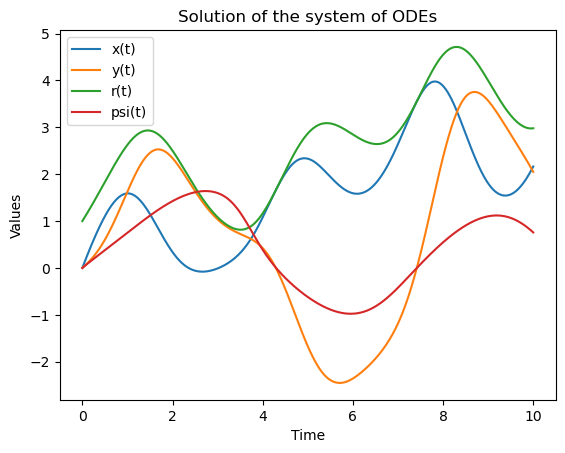

In [ ]:

# Example of omega(t) and psi0(t)
def omega(t):
    return np.sin(t)  # Example function for omega

def psi0(t):
    return np.cos(t)  # Example function for psi0

# Initial conditions
y0 = [0.0, 0.0, 1.0, 0.0]  # Initial values for x, x_dot, r, psi

# Time span
t_span = (0, 10)  # From t=0 to t=10
t_eval = np.linspace(0, 10, 1000)  # Points at which to store the solution

# Parameters
R0 = 1.0
phi0 = 0.0
sigma_v = 0.1
sigma_h = 0.1
h = 1.0
theta0 = 0.0

# Solve the system of ODEs
sol = solve_ivp(system_of_odes, t_span, y0, t_eval=t_eval, args=(R0, phi0, sigma_v, sigma_h, h, psi0, theta0, omega))

# Plot the solution
plt.figure()
plt.plot(sol.t, sol.y[0], label='x(t)')
plt.plot(sol.t, sol.y[1], label='y(t)')
plt.plot(sol.t, sol.y[2], label='r(t)')
plt.plot(sol.t, sol.y[3], label='psi(t)')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Solution of the system of ODEs')
plt.show()

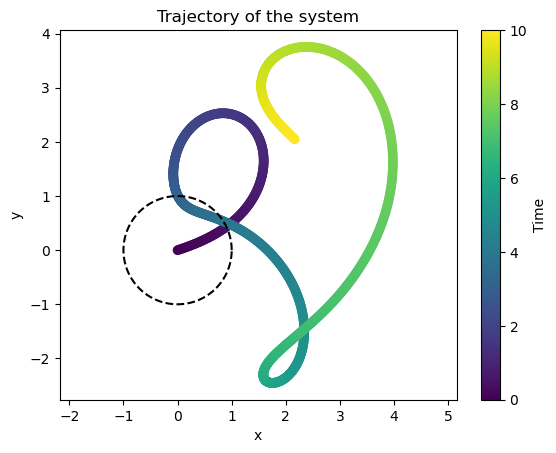

In [ ]:

# Plot the solution
plt.figure()
# plot x, y on the 2d plane, colored by sol.t
plt.scatter(sol.y[0], sol.y[1], c=sol.t)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory of the system')
plt.colorbar(label='Time')
# plot the unit circle
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k--')
plt.axis('equal')
plt.show()

# plt.plot(sol.t, sol.y[0], label='x(t)')
# plt.plot(sol.t, sol.y[1], label='y(t)')
# plt.plot(sol.t, sol.y[2], label='r(t)')
# plt.plot(sol.t, sol.y[3], label='psi(t)')
# plt.xlabel('Time')
# plt.ylabel('Values')
# plt.legend()
# plt.title('Solution of the system of ODEs')
# plt.show()

In [ ]:
t_span = (0, 100)  # From t=0 to t=10
t_eval = np.linspace(0, 100, 1000)  # Points at which to store the solution

# Speed, angular velocity, and head direction input signals
omega_fun = lambda t: -0.1
h_fun = lambda t: max(0, 0.1 * (1.5 + np.cos(0.1 * t)))
psi0_fun = lambda t: np.pi/2 + 0.1 * t #-0.2* t  # Example function for psi0
# Manifold Parameters
R0 = 1.0
eps = 0.25
phi0 = - np.pi/2
# Relative confidance in velocity and head direction signal, gating term of input. 
sigma_v = 0.1
sigma_h = 0.1
# h = 0.5
theta0 = 0.0 # this one is useless, can be combined into psi0
# Initial conditions
y0 = [3.0, 0.0,]  # Initial values for x, x_dot, r, psi

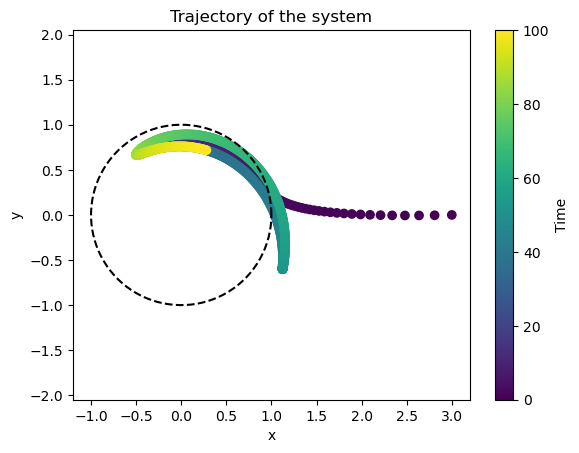

In [ ]:

# Plot the solution
plt.figure()
# plot x, y on the 2d plane, colored by sol.t
plt.scatter(sol.y[0], sol.y[1], c=sol.t)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectory of the system')
plt.colorbar(label='Time')
# plot the unit circle
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(np.cos(theta), np.sin(theta), 'k--')
plt.axis('equal')
plt.show()

# plt.plot(sol.t, sol.y[0], label='x(t)')
# plt.plot(sol.t, sol.y[1], label='y(t)')
# plt.plot(sol.t, sol.y[2], label='r(t)')
# plt.plot(sol.t, sol.y[3], label='psi(t)')
# plt.xlabel('Time')
# plt.ylabel('Values')
# plt.legend()
# plt.title('Solution of the system of ODEs')
# plt.show()